In [1]:
!pip install pyspark
import pyspark
from pyspark import SparkContext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d17c929833af5144127090a513d6dee2f2a97f449fd509a4983e65305b878efd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from random import Random
import networkx as nx
G = nx.DiGraph()

In [3]:
num_vertice = 5
num_edges = 10
rand = Random(42)

In [4]:
def generate_random_graph():
  edges = set()
  while len(edges) < num_edges:
    src = rand.randrange(0, num_vertice)
    end = rand.randrange(0, num_vertice)
    if src != end:
      edges.add((src, end))
  return edges

In [5]:
edges = generate_random_graph()
edges

{(0, 2),
 (0, 3),
 (0, 4),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (3, 0),
 (3, 1),
 (3, 4)}

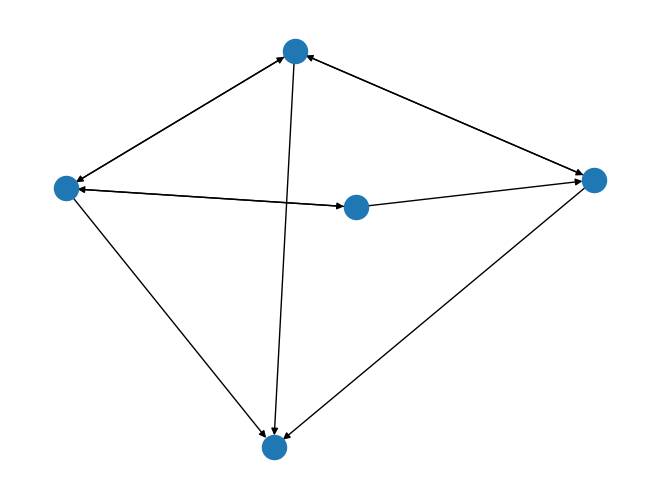

In [6]:
G.add_edges_from(edges)
nx.draw(G)

In [7]:
sc = SparkContext()

In [8]:
reachable = sc.parallelize(edges)

In [9]:
edges = reachable.map(lambda e: ((e[1], e[0])))

In [10]:
reachable.join(edges).collect()

[(0, (4, 2)),
 (0, (4, 3)),
 (0, (3, 2)),
 (0, (3, 3)),
 (0, (2, 2)),
 (0, (2, 3)),
 (1, (4, 2)),
 (1, (4, 3)),
 (1, (3, 2)),
 (1, (3, 3)),
 (2, (1, 0)),
 (2, (0, 0)),
 (3, (4, 0)),
 (3, (4, 1)),
 (3, (1, 0)),
 (3, (1, 1)),
 (3, (0, 0)),
 (3, (0, 1))]

In [11]:
#for _ in range(10):
while True:
  old_count = reachable.count()
  attainable = reachable.join(edges).map(lambda element: (element[1][1], element[1][0]))
  reachable = reachable.union(attainable).distinct()
  if reachable.count() == old_count:
    break

In [12]:
reachable.collect()

[(1, 2),
 (1, 0),
 (2, 1),
 (2, 3),
 (0, 4),
 (0, 2),
 (3, 2),
 (3, 0),
 (0, 0),
 (1, 1),
 (2, 0),
 (3, 3),
 (0, 3),
 (0, 1),
 (1, 3),
 (1, 4),
 (2, 2),
 (2, 4),
 (3, 1),
 (3, 4)]

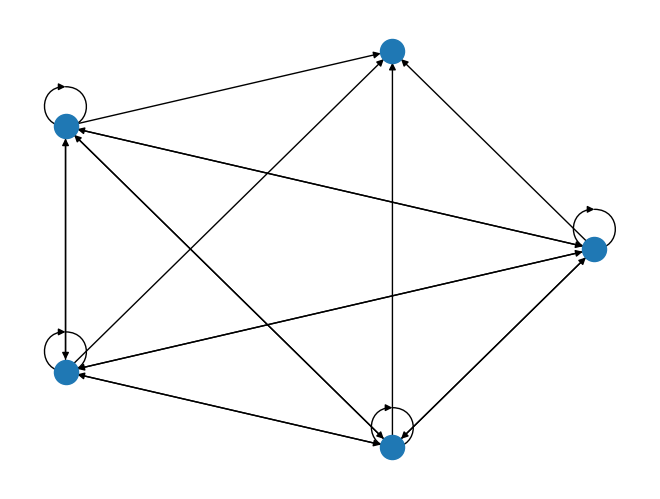

In [13]:
A = _
G.add_edges_from(A)
nx.draw_circular(G)

**4.2**

In [15]:
import numpy as np
matrix1 = [
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
]

matrix2 = np.array([
    [9.0, 8.0, 7.0],
    [6.0, 5.0, 4.0],
    [3.0, 2.0, 1.0]
])

In [17]:
rows1 = sc.parallelize(matrix1)
rows2 = sc.parallelize(matrix2)

In [18]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import DenseMatrix
import numpy as np
m1 = RowMatrix(rows1)
m2 = np.array(matrix2).flatten()
m2 = DenseMatrix(matrix2.shape[0], matrix2.shape[1], m2)

In [19]:
for vector in m1.multiply(m2).rows.collect():
  print(vector)

[46.0,28.0,10.0]
[118.0,73.0,28.0]
[190.0,118.0,46.0]


In [20]:
A = [1, 2, 3, 4, 5]
B = [4, 5, 6, 7, 8]


In [21]:
rdd_A = sc.parallelize(A)
rdd_B = sc.parallelize(B)

In [22]:
sum = rdd_A.map(lambda x: (x, 'A')).union(rdd_B.map(lambda x: (x, 'B'))).reduceByKey(lambda x, y: x).map(lambda x: x[0]).collect()
sorted(sum)

[1, 2, 3, 4, 5, 6, 7, 8]

In [23]:
intersect = rdd_A.map(lambda x: (x, 'A')).union(rdd_B.map(lambda x: (x, 'B'))).groupByKey().filter(lambda x: len(x[1]) == 2).map(lambda x: x[0]).collect()
sorted(intersect)

[4, 5]

In [24]:
diff = rdd_A.map(lambda x: (x, 'A')).subtractByKey(rdd_B.map(lambda x: (x, 'B'))).map(lambda x: x[0]).collect()
sorted(diff)

[1, 2, 3]

In [25]:
customers_data = [(1, "John"), (2, "Alice"), (3, "Bob")]
orders_data = [(1, 101, 50), (2, 102, 100), (1, 103, 75), (3, 104, 200)]

In [26]:
customers = sc.parallelize(customers_data)
orders = sc.parallelize(orders_data)

In [27]:
customers = customers.map(lambda x: (x[0], (x[1])))
orders = orders.map(lambda x: (x[0], (x[1], x[2])))

In [28]:
join = customers.union(orders).groupByKey().map(lambda x: list(x[1])).collect()
join

[['John', (101, 50), (103, 75)], ['Alice', (102, 100)], ['Bob', (104, 200)]]